In [1]:
# Dependencies
from census import Census
from config import (census_key, yelp_api_key, gkey)
import numpy as np
import pandas as pd
import requests
import time
from matplotlib import pyplot as plt
import random
from yelpapi import YelpAPI
from pprint import pprint
import gmaps

# Census API Key
c = Census(census_key, year=2013)

In [2]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
census_data = c.acs5.get(("B01003_001E", "B17001_002E", "B19301_001E","B17001_003E", "B17001_017E"), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B17001_002E": "Poverty Count",
                                      "B19301_001E": "Income Per Capita",
                                      "B17001_003E": "Men Living in Poverty",
                                      "B17001_017E": "Females Living in Poverty",
                                      "zip code tabulation area": "Zipcode"})

# Add in Employment Rate (Employment Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Income Per Capita","Poverty Rate", 
                       "Poverty Count", "Men Living in Poverty", "Females Living in Poverty"]]

# Visualize
print(len(census_pd))
census_pd.head()

33120


,Zipcode,Population,Income Per Capita,Poverty Rate,Poverty Count,Men Living in Poverty,Females Living in Poverty
0,01832,22121.0,29014.0,10.903666,2412.0,1156.0,1256.0
1,01833,8295.0,43297.0,2.302592,191.0,88.0,103.0
2,01834,6675.0,40222.0,2.187266,146.0,53.0,93.0
3,01835,13527.0,31429.0,8.523693,1153.0,560.0,593.0
4,01840,4547.0,14758.0,39.542556,1798.0,696.0,1102.0


In [3]:
# Import the original data we analyzed earlier. Use dtype="object" to match other
census_data_orig = pd.read_csv("Resources/zip_bank_data.csv", dtype="object", encoding="utf-8")

# Visualize
census_data_orig.head()

,Zipcode,City,State,Zip Code,Country,Median Age,Household Income,Per Capita Income,Lat,Lng,Bank Count
0,624,Hastings,MI,49058,USA,40.8,46777,22137,42.6306916,-85.2929384,9
1,692,Ball,LA,71405,USA,35.8,55242,23941,31.4061799,-92.396174,12
2,730,Great Mills,MD,20634,USA,31.9,79944,35961,38.2201614,-76.4967919,9
3,757,Williamsport,TN,38487,USA,41.6,38125,18884,35.7310368,-87.2419299,0
4,957,Marion,ND,58466,USA,44.5,69844,36981,46.5594224,-98.3481542,1


In [4]:
# Merge the two data sets along zip code
census_data_complete = pd.merge(
    census_data_orig, census_pd, how="left", on=["Zipcode", "Zipcode"])

# Remove rows missing data
census_data_complete = census_data_complete.dropna()

#Rename Columns
census_data_complete = census_data_complete.rename(columns = {'Address':'City'})

#Drop unnecessary columns
census_data_complete = census_data_complete.drop(columns=['Zipcode','Per Capita Income', 'Bank Count', 'Country'])

# Visualize
census_data_complete.head()

,City,State,Zip Code,Median Age,Household Income,Lat,Lng,Population,Income Per Capita,Poverty Rate,Poverty Count,Men Living in Poverty,Females Living in Poverty
63,Flatonia,TX,78941,45.7,40304,29.7574106,-97.1574784,6525.0,157713.0,2.206897,144.0,61.0,83.0
64,Nevada,IA,50201,40.4,56619,42.065743,-93.4599326,24537.0,22077.0,21.828259,5356.0,2334.0,3022.0
65,Lukachukai,AZ,86507,24.1,22009,36.4106866,-109.2593642,32646.0,35719.0,6.766526,2209.0,908.0,1301.0
66,Lone Pine,CA,93545,40.6,32473,36.5131184,-118.0888578,9895.0,26137.0,15.260232,1510.0,620.0,890.0
67,Niagara,WI,54151,45.7,45813,45.715354,-87.9804239,12439.0,73808.0,3.006673,374.0,122.0,252.0


In [5]:
#Same census date with state as the index
census_data_complete_state = census_data_complete.set_index('State')
census_data_complete_state.head()

,City,Zip Code,Median Age,Household Income,Lat,Lng,Population,Income Per Capita,Poverty Rate,Poverty Count,Men Living in Poverty,Females Living in Poverty
State,,,,,,,,,,,,
TX,Flatonia,78941,45.7,40304,29.7574106,-97.1574784,6525.0,157713.0,2.206897,144.0,61.0,83.0
IA,Nevada,50201,40.4,56619,42.065743,-93.4599326,24537.0,22077.0,21.828259,5356.0,2334.0,3022.0
AZ,Lukachukai,86507,24.1,22009,36.4106866,-109.2593642,32646.0,35719.0,6.766526,2209.0,908.0,1301.0
CA,Lone Pine,93545,40.6,32473,36.5131184,-118.0888578,9895.0,26137.0,15.260232,1510.0,620.0,890.0
WI,Niagara,54151,45.7,45813,45.715354,-87.9804239,12439.0,73808.0,3.006673,374.0,122.0,252.0


In [6]:
#Grab 100 random cities from Data Frame
cities_df = census_data_complete_state['City']
city_sample = random.sample(list(cities_df), 100)

#Create lists for values we want to extract
state_list = []
income_capita = []
income_household = []
lng = []
lat = []

#Iterate through the cities to grab data
for city in city_sample:
    sample_df=census_data_complete.loc[census_data_complete["City"] == city]
    state_list.append(sample_df.iloc[0,1])
    income_capita.append(sample_df.iloc[0,8])
    income_household.append(sample_df.iloc[0,4])
    lng.append(sample_df.iloc[0,6])
    lat.append(sample_df.iloc[0,5])

,City,State,Zip Code,Median Age,Household Income,Lat,Lng,Population,Income Per Capita,Poverty Rate,Poverty Count,Men Living in Poverty,Females Living in Poverty
333,Century,FL,32535,37.8,34107,30.9724762,-87.3711477,2541.0,19849.0,13.341204,339.0,175.0,164.0


In [8]:
#Use Yelp's API & create lists for city and total number of restaurants
yelp_api = YelpAPI(yelp_api_key)
total_fastfood_city = []
city_list = []

#Iterate through and append values to the lists 
for city in city_sample:
    
    search_results = yelp_api.search_query(term = 'fast food', location = city)
    total_fastfood_city.append(search_results['total'])
    city_list.append(city)

In [9]:
#Create DataFrame 
total_fastfood_city_df = pd.DataFrame({'State': state_list,
                                    'City': city_list,
                                    'Number of Fast Food':total_fastfood_city,
                                      'Income Per Capita':income_capita,
                                      'Household Income': income_household,
                                      'Lat':lat,
                                      'Lng':lng})

total_fastfood_city_df.head()

,State,City,Number of Fast Food,Income Per Capita,Household Income,Lat,Lng
0,FL,Century,9,19849.0,34107,30.9724762,-87.3711477
1,UT,Draper,521,20860.0,89922,40.4960215,-111.8687825
2,WY,Farson,29,22759.0,91115,42.1543456,-109.4259114
3,PA,Unityville,54,15101.0,45795,41.2642364,-76.5257007
4,VA,McLean,1600,22939.0,112427,38.9586422,-77.2290193


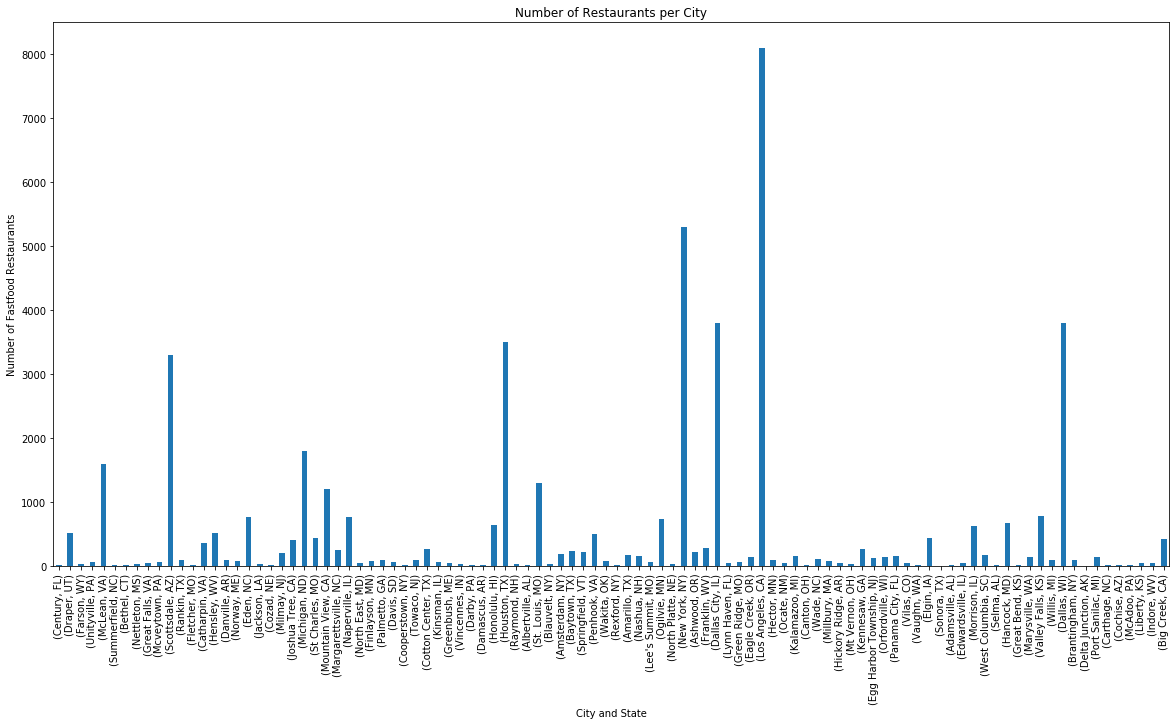

In [10]:
#Create Bar graph of number of restaurants per city
total_fastfood_city_df_index_city=total_fastfood_city_df.set_index(['City', 'State'])
total_fastfood_city_df_index_city["Number of Fast Food"].plot(kind="bar", figsize=(20,10))
plt.xlabel("City and State")
plt.ylabel("Number of Fastfood Restaurants")
plt.title("Number of Restaurants per City")
plt.show()

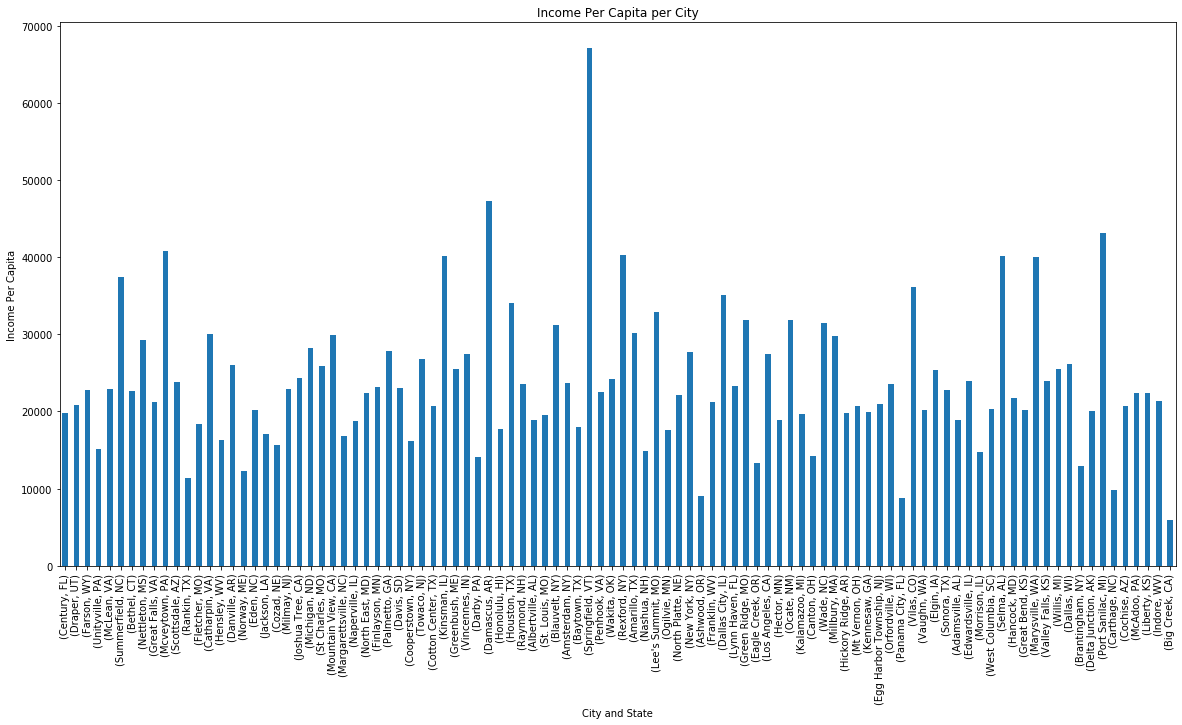

In [11]:
total_fastfood_city_df_index_city["Income Per Capita"].plot(kind="bar", figsize=(20,10))
plt.xlabel("City and State")
plt.ylabel("Income Per Capita")
plt.title("Income Per Capita per City")
plt.show()

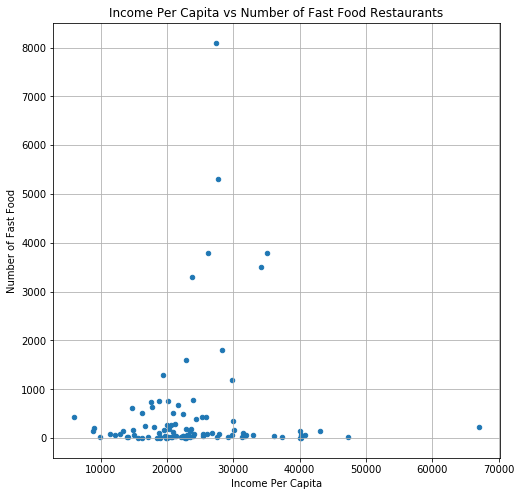

In [12]:
total_fastfood_city_df_index_city.plot(kind='scatter', x = 'Income Per Capita', y = 'Number of Fast Food', grid = True, figsize=(8,8))
plt.title("Income Per Capita vs Number of Fast Food Restaurants")
plt.show()

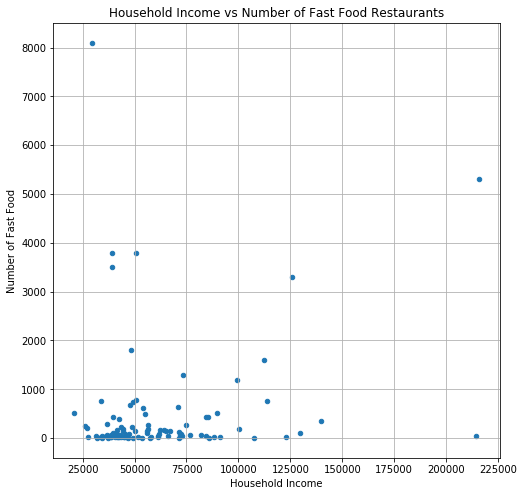

In [13]:
total_fastfood_city_df_index_city["Household Income"] = total_fastfood_city_df_index_city["Household Income"].astype(int)
total_fastfood_city_df_index_city.plot(kind='scatter', x = 'Household Income', y = 'Number of Fast Food', grid = True, figsize=(8,8))
plt.title("Household Income vs Number of Fast Food Restaurants")
plt.show()

In [15]:
#Calculate the IQR and quantitatively determine if there are any potential outliers. 
house_income =total_fastfood_city_df['Household Income'].astype(int)

quartiles = house_income.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of Household Income is: {lowerq}")
print(f"The upper quartile of Household Income is: {upperq}")
print(f"The interquartile range of Household Income is: {iqr}")
print(f"The the median of Household Income is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outlier_ff = total_fastfood_city_df.loc[(house_income < lower_bound) | (house_income > upper_bound)]
outlier_ff

The lower quartile of Household Income is: 40759.25
The upper quartile of Household Income is: 71445.0
The interquartile range of Household Income is: 30685.75
The the median of Household Income is: 49266.0 
Values below -5269.375 could be outliers.
Values above 117473.625 could be outliers.


,State,City,Number of Fast Food,Income Per Capita,Household Income,Lat,Lng
8,VA,Great Falls,45,21209.0,214219,39.0188593,-77.3094674
10,AZ,Scottsdale,3300,23841.0,125884,33.791108,-111.8091625
13,VA,Catharpin,360,30000.0,139938,38.8568373,-77.5676735
32,NJ,Towaco,94,26832.0,129432,47.9623949,-92.8937893
44,NY,Blauvelt,28,31249.0,122857,41.0711228,-73.9536163
56,NY,New York,5300,27733.0,216037,40.7136487,-74.0087126


In [16]:
gmaps.configure(api_key=gkey)

locations = total_fastfood_city_df[["Lat", "Lng"]].astype(float)
total_restaurants = total_fastfood_city_df["Number of Fast Food"].astype(float)

fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=total_restaurants, dissipating=False, max_intensity=65,
                                 point_radius = 0.5)
fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))